<a href="https://colab.research.google.com/github/jedhouas/Probabilistic-Graphical-Models/blob/master/HW3_HOUAS_CHAFROUDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center>Homework 3: Gibbs sampling and mean field VB for the probit model</center></h1>

##### Jed HOUAS


1)

In [0]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.stats import truncnorm,mode
import time

In [0]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data-numeric

--2020-01-24 16:57:12--  https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data-numeric
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102000 (100K) [application/x-httpd-php]
Saving to: ‘german.data-numeric’

german.data-numeric 100%[===================>]  99.61K   498KB/s    in 0.2s    

2020-01-24 16:57:13 (498 KB/s) - ‘german.data-numeric’ saved [102000/102000]



In [0]:
data = pd.read_csv('/content/german.data-numeric', header= None, delimiter= '\s+', index_col=False)
X=data.iloc[:,:-1]
cols = ["x"+str(i) for i in X.columns]
X.columns = cols
y=data.iloc[:,-1]
#Normalisation
X=(X-X.mean())/X.std()
#adding a constant column 
X.insert(0,'cte', 1)
#casting y values to +1 / -1 
y=y*2-3

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=.2)

In [0]:
(X_train.T@X_train).shape

(25, 25)

###3) Gibbs Sampling


we need to sequentially sample the following ( we start off with a burn in period) :(check report for more details ) 
*  $\beta^{t+1} \sim p(\beta|z^t) = \mathcal N(\mu_p^t, \Sigma_p) ,\quad
    \Sigma_p = (\frac1\tau I_p + X^TX)^{-1},
    \quad
    \mu^t = \Sigma_p X^Tz 
$

*  $z^{t+1} \sim \mathcal{N} (x_i^T\beta, 1; y_i)[z_i y_i>0] \quad \text{such that }p(z|\beta^{t+1},y^t) = \exp(-\frac12\|z-X\beta\|^2) \prod_i \mathbf{1}_{\{y_iz_i > 0\}}$






In [0]:
class GibbsSampler:
  
    def __init__(self,tau=10**2, burn_in=1000):
        self.burn_in = burn_in
        self.tau = tau

    def sample(self,X,y, n_iter):
        """Sampling from the posterior distribution.
        -----------------------------------------------------------------
        Input:
            n_iter : number of iterations 
        ------------------------------------------------------------------            
        Output:
            beta_samples, z_samples : samples from the posterior 
        """
        n,p = X.shape
        # posterior dist init 
        # covariance matrix
        cov_ = np.linalg.inv(np.eye(p)/ self.tau + X.T @ X) 
        #z randomly initialized : 
        z = np.random.randn(n)
        # mean
        mu = cov_@X.T@z
        temp = cov_ @ X.T #we don't need to calculate this every time
        beta_samples= []
        z_samples=[]
        for t in range(self.burn_in+n_iter):
            ## Sample beta
            beta = np.random.multivariate_normal(mu, cov=cov_)
            ## Sample z
            mean = X@beta
            a=np.where(y<0,-np.inf,-mean)
            b=np.where(y>0,np.inf,-mean)
            z= truncnorm.rvs(a, b, loc=mean)
            mu = temp @ z  # shape (d,)
            if t >= self.burn_in:
                beta_samples+=[beta]
                z_samples+=[z]
        return np.array(beta_samples), np.array(z_samples)

In [0]:
gi_sampler = GibbsSampler(burn_in=1000)
start_time = time.time()
betas, zs = gi_sampler.sample(X_train,y_train,5000)
print("Sampling Time: %.3f" % (time.time()-start_time))

Sampling Time: 82.878


<Figure size 792x432 with 0 Axes>

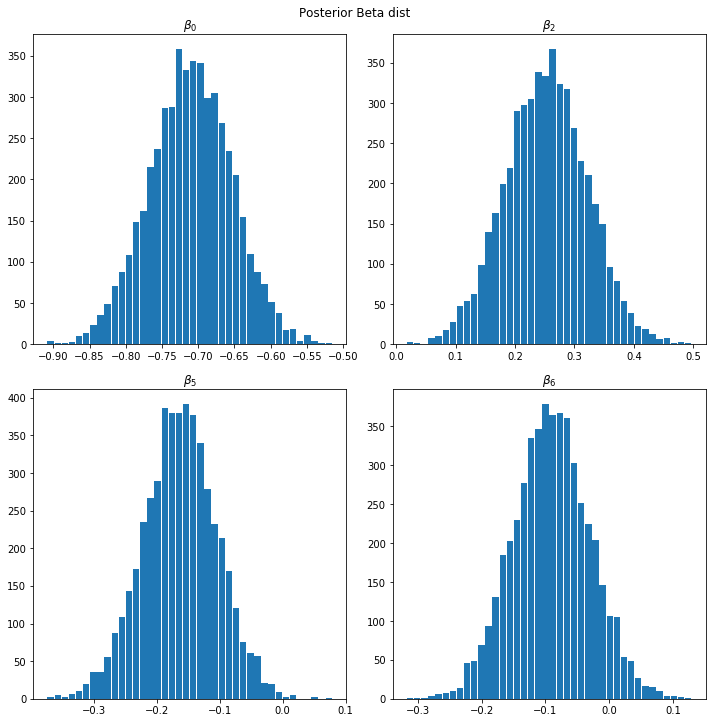

In [0]:
fig = plt.figure(figsize=(11, 6))
nrows = 2
ncols = 2
n_bins = 40
fig,axes=plt.subplots(nrows,ncols,figsize=(10,10))
axes=axes.ravel()
indices=[0,2,5,6]
for i,idx in enumerate(indices):
  axes[i].hist(betas[:, idx], bins=n_bins,rwidth=.9 )
  axes[i].set_title('$\\beta_{%d}$' % idx)
fig.tight_layout()
fig.suptitle("Posterior Beta dist ", y=1.);

<Figure size 792x432 with 0 Axes>

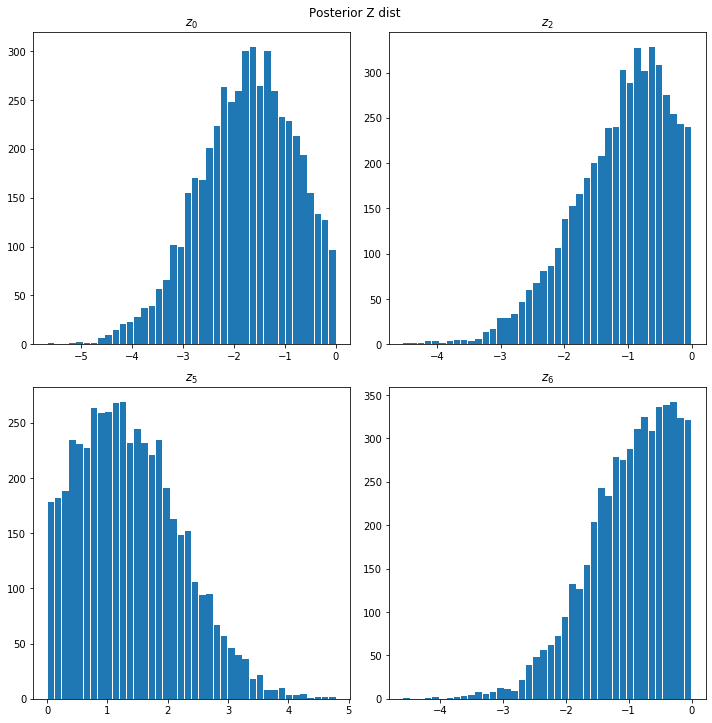

In [0]:
fig = plt.figure(figsize=(11, 6))
nrows = 2
ncols = 2
n_bins = 40
fig,axes=plt.subplots(nrows,ncols,figsize=(10,10))
axes=axes.ravel()
indices=[0,2,5,6]
for i,idx in enumerate(indices):
  axes[i].hist(zs[:, idx], bins=n_bins,rwidth=.9 )
  axes[i].set_title('$z_{%d}$' % idx)
fig.tight_layout()
fig.suptitle("Posterior Z dist ", y=1.);

In [0]:
def predict(X,betas):
        n= X.shape[0]
        n_samples=betas.shape[0]
        Z = X @betas.T + np.random.randn(n,n_samples )
        Y=np.sign(np.sum(np.sign(Z),axis=1))
        return Y #return most probable output 

In [0]:
y_pred=predict(X_test,betas)

we get an accuracy of around 80%





In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

          -1       0.81      0.90      0.85       135
           1       0.72      0.55      0.63        65

    accuracy                           0.79       200
   macro avg       0.76      0.73      0.74       200
weighted avg       0.78      0.79      0.78       200



###4) Mean filed variational algorithm

In [0]:
from scipy.special import erf

def compute_Ez(i,y_i,mu_i): # attention y_i =2,1
    if y_i == 2 :
        return mu_i+np.sqrt(2/np.pi)*np.exp(-mu_i**2)/(1-erf(-mu_i/np.sqrt(2)))
    return mu_i - np.sqrt(2/np.pi)*np.exp(-mu_i**2)/(1+erf(-mu_i/np.sqrt(2)))

def compute_Epz(X,m,S):
    A = np.dot(m,m.T)
    for i in range(S.shape[0]):
        for j in range(S.shape[1]):
            A[i][j] = A[i][j]+S[i][j]
    return -(np.matrix.trace(np.dot(np.dot(X.T,X),A)))/2.0

def compute_Eqz(y,mu,n):
    sum_ = 0
    for i in range(n):
        phi_i = (erf(-mu[i][0]/np.sqrt(2))+1)/2.0
        sum_ += (mu[i][0]**2)/2.0 + (y[i][0]-1)*np.log(1-phi_i)+(1-(y[i][0]-1))*np.log(phi_i)
    return -sum_

def compute_Epbeta(m,S,tau,p):
    return -(np.sum(np.dot(m.T,m))+np.matrix.trace(S))/(2.0*tau)-(np.log(2.0*np.pi)+np.log(tau))*(p-1)/2.0

def compute_Eqbeta(S):
    return -np.log(abs(np.linalg.det(S)))/2.0-(1+np.log(2.0*np.pi))/2.0

def compute_bound(data,m,S,tau,mu):
    n,p = data.shape
    X = data.iloc[:,:-1].values
    y = np.array([data.iloc[:,p-1].values]).T
    print('epz',compute_Epz(X,m,S))
    print('eqz',compute_Eqz(y,mu,n))
    print('epbeta',compute_Epbeta(m,S,tau,p))
    print('eqbeta',compute_Eqbeta(S))
    return compute_Epz(X,m,S)-compute_Eqz(y,mu,n)+compute_Epbeta(m,S,tau,p)-compute_Eqbeta(S)

def init_gibbs_sampling(data,p,tau,n):
    m_beta = [0 for i in range(p-1)]
    V_beta = np.diag([tau for i in range(p-1)])
    
    beta = np.array([[0 for i in range(p-1)]]).T
    z = np.array([[0 for i in range(n)]]).T

    return m_beta,V_beta,beta,z

def compute_param_beta(X,V):
    S = np.linalg.inv(np.dot(X.T,X)+np.linalg.inv(V)) 
    m_ = np.dot(S,X.T)
    return m_,S

def mean_field(data,N_iter,tau,eps):
    n,p = data.shape
    m_beta0,V_beta,beta0,z0 = init_gibbs_sampling(data,p,tau,n) # prendre V_beta de gibbs prior variance de beta 
    m_beta0 = np.array([m_beta0]).T
    # compute parameters of beta
    m_,S = compute_param_beta(data.iloc[:,:-1].values,V_beta) #mean operator, même variance  
    #print(m_beta0,m_beta0.shape)
    # mean gaussienne tronquee
    mu = np.dot(data.iloc[:,:-1].values,m_beta0)
    #print(mu,mu.shape)
    # vecteur mean de z suivant q(z)
    E_qz = np.zeros([n,1])
    for i in range(n):
        E_qz[i][0] = compute_Ez(i,data.iloc[i,p-1],mu[i][0])
    print(E_qz)
    m_beta = np.dot(m_,E_qz)
    print(m_beta,m_beta.shape)
    # lower bound
    print(compute_bound(data,m_beta,S,tau,mu))
    store_bound = [10000]
    store_mbeta = np.zeros([N_iter,p-1])
    converge = False
    t = 1
    while (converge==False):
        # mean gaussienne tronquee
        mu = np.dot(data.iloc[:,:-1].values,m_beta0)
        # vecteur expectation de z suivant q(z)
        for i in range(n):
            E_qz[i][0] = compute_Ez(i,data.iloc[i,p-1],mu[i][0])
        #mean beta
        m_beta = np.dot(m_,E_qz)
        #update 
        m_beta0 = m_beta   
        store_mbeta[t] = [m_beta[i][0] for i in range(p-1)]
        
        # lower bound
        store_bound.append(compute_bound(data,m_beta,S,tau,mu))
        if abs(store_bound[t]-store_bound[t-1])<eps:
            converge = True
        print(t,store_bound[t])
        t+=1
        if (t==N_iter):
            converge=True
            print('not converged')
    print(store_mbeta[t-1])
    return store_bound, store_mbeta

In [0]:
data_normalized = pd.DataFrame(index=data.index)
for j in range(data.shape[1]):
    data_normalized[str(j)] = np.array([[1 for k in range(len(data.index))]]).T
for i in range(data.shape[0]):
    moy = np.mean(data.iloc[i,:data.shape[1]-1].T)
    std = np.std(data.iloc[i,:data.shape[1]-1].T)
    for j in range(1,data.shape[1]):
        data_normalized.iloc[i,j] = (data.iloc[i,j-1]-moy)/std
data_normalized[str(data.shape[1])] = data.iloc[:,data.shape[1]-1]
data_normalized["25"] = data[24]
d_train = data_normalized.iloc[:int(0.8*data_normalized.shape[0]),:]
d_test = data_normalized.iloc[int(0.8*data_normalized.shape[0]):,:]
y_test = d_test.iloc[:,-1]
for i in range(len(y_test)):
  if y_test.iloc[i] == 2:
    y_test.iloc[i] = 1
  else:
    y_test.iloc[i] = -1
eps = 1e-08
N_iter = 10000
tau=10**2
#data_MF = X
#data_MF["y"] = y
start_time = time.time()
store_bound,store_mbeta = mean_field(d_train,N_iter,tau,eps)
print("Sampling Time: %.3f" % (time.time()-start_time))

In [0]:
def predict_MF(X,betas):
  n= X.shape[0]
  n_samples=betas.shape[0]
  Z = X @betas.T + np.random.randn(n,n_samples )
  Y=np.sign(np.sum(np.sign(Z),axis=1))
  for i in range(len(Y)):
    if Y.iloc[i] == 0:
      Y.iloc[i] = 1
  return Y #return most probable output 
y_pred=predict_MF(d_test.iloc[:,:-1],store_mbeta)

from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

          -1       0.81      0.85      0.83       139
           1       0.61      0.54      0.57        61

    accuracy                           0.76       200
   macro avg       0.71      0.69      0.70       200
weighted avg       0.75      0.76      0.75       200



# Question 6

Complete separation occurs in a dataset if there exists β such that
$y_iβ\beta^Tx_i > 0 $ for all the datapoints.  maximum likelihood estimation is not  possible in this  case but we'll see that Gibbs sampling performs very well. 

## Creating synthetic Completely seperable dataset 

In [0]:
x = np.random.randn(500, 2)
beta = np.array([1.5, 1.5])
sep = x @ beta + 2 > 0.
x1 = x[sep]+[0.5,0.5]
x2 = x[~sep]-[0.5,.5]#we add more seperation like this 

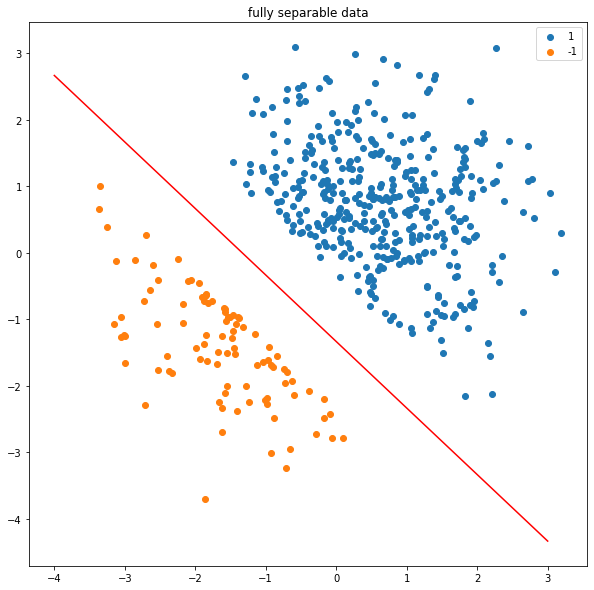

In [0]:
fig = plt.figure(figsize=(10,10))
plt.scatter(*x1.T,label="1")
plt.scatter(*x2.T,  label="-1")
t=np.linspace(-4,3,10)
line=(beta[0]*t+2)/(-beta[1])
plt.plot(t,line,color='r')
plt.title("fully separable data")
plt.legend()

## Testing Our Gibbs Sampler on the separable Dataset 

In [0]:
X=np.vstack((x1,x2))
y = np.ones((x.shape[0],))
y1 = y[sep]
y2 = -y[~sep]
Y=np.append(y1,y2)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2)

In [0]:
gi_sampler = GibbsSampler(burn_in=1000)
start_time = time.time()
betas, zs = gi_sampler.sample(X_train,y_train,5000)
print("Sampling time: %.3f" % (time.time()-start_time))

Sampling time: 24.706


In [0]:
y_pred=predict(X_test,betas)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

        -1.0       0.88      1.00      0.94        15
         1.0       1.00      0.98      0.99        85

    accuracy                           0.98       100
   macro avg       0.94      0.99      0.96       100
weighted avg       0.98      0.98      0.98       100

